# Проект "Исследование объявлений о продаже квартир"

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

В базу данных входит такая информация, как дата создания объявления о продаже квартиры, длительность объявления и конечная стоимость продажи. Такжже имеются характеристики квартиры - общая, жилая и кухонная площадь, высота потолков, число балконов и комнат. Расположение недвижимости описывают данные об этажности дома и этаже самой квартиры, её удаленность от парков, прудов, центра города и ближайшего аэропорта. Помимо этого имеются несколько булевых столбцов, описывающих, является ли квартира апартаментом или студией, а также есть ли в ней свободная планировка.

В процессе работы нам предстоит провести предобработку полученных данных на предмет наличия и заполнения пропуска, поиск явных и неявных дубликатов, а также преобразование типов данных, где это необходимо. После этого необходимо будет добавить в нашу таблицу дополнительные столбцы с данными, которые будут вычислены из уже имеющихся либо просто их категоризуют, и помогут нам в дальнейшем анализе. 

Как только мы перейдем непосредственно к анализу, в первую очередь нужно будет проверить основные интересующие нас столбцы на предмет аномалий в данных и/или выбросов. Аномалии необходимо будет обработать, по возможности исправить или удалить, а выбросы - отсечь для того, чтобы они не влияли на конечный результат.

После этого перейдем к дальнейшему исследовательскому анализу, который уже будет непосредственно полезен для бизнеса. Нам предстоит оценить среднюю скорость продажи квартир, что считается быстрой продажей, а что - слишком длительной. Проанализуем, какие основные факторы больше всего влияют на стоимость объекта недвижимости. Рассчитаем среднюю цену квадратного метра жилья для основных населенных пунктов. А также проанализируем, как меняется стоимость одного квадратного метра в среднем при удалении от центр города Санкт-Петербурга.

В конечном итоге подведём итоги проекта и сделаем общий вывод.

### Открываем файл с данными и изучаем общую информацию. 

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# открываем и изучаем dataset
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

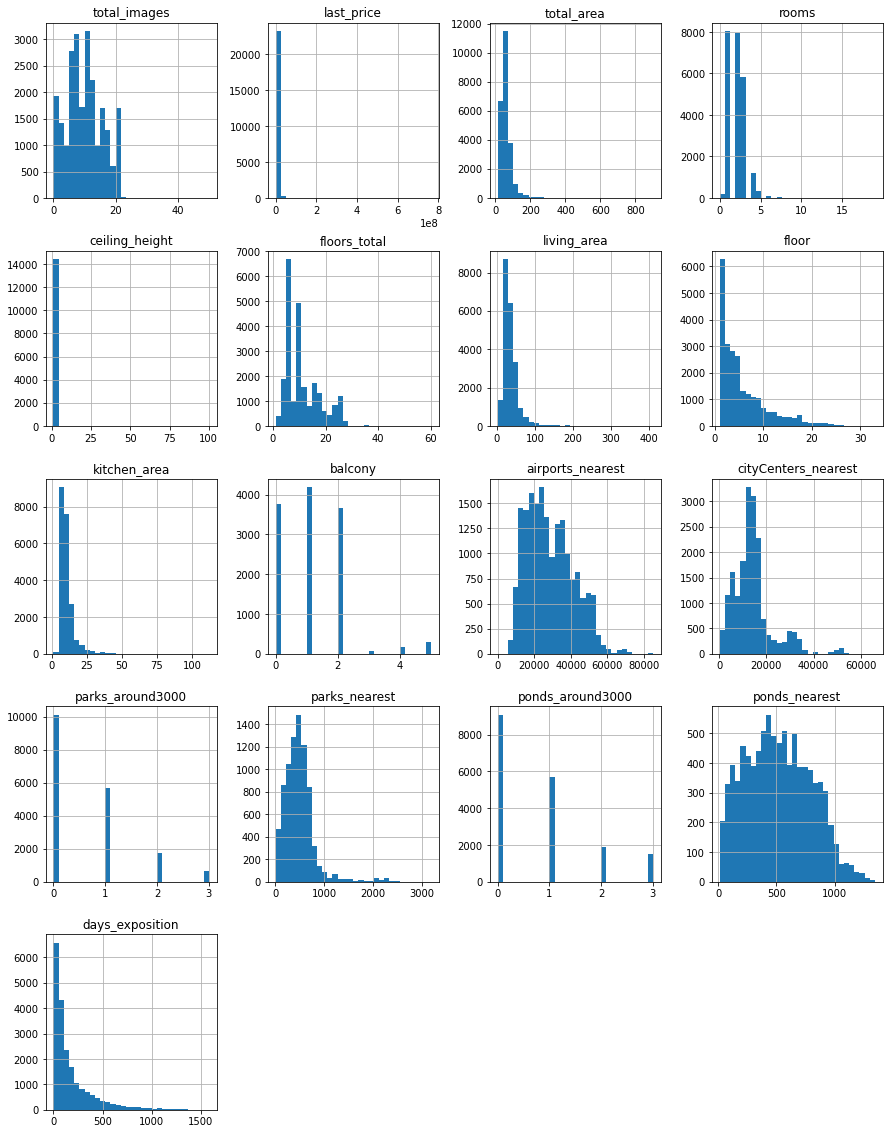

In [3]:
# строим гистограммы для визуализации данных
data.hist(figsize=(15, 20), bins=30)
None

Как мы можем видеть, на большей части гистограмм имеются выбросы и/или аномалии, которые искажают график. Как только доберемся до шага с анализом данных, придётся более детально разобраться, что с ними делать - заменять, удалять или просто не учитывать в анализе. Возможно, также графики еще изменятся после предобработки данных, работы с пропусками и дубликатами.

### Предобработка данных

#### Работа с пропусками

In [5]:
# определим все столбцы, в которых содержится хотя бы 1 пропуск
nan_column_list = []
for i in data.columns:
    if data[i].isna().sum() > 0:
        nan_column_list.append(i)

nan_column_list = pd.DataFrame({'column_name': nan_column_list})    
nan_column_list
# таких столбцов 14

,column_name
0,ceiling_height
1,floors_total
2,living_area
3,is_apartment
4,kitchen_area
5,balcony
6,locality_name
7,airports_nearest
8,cityCenters_nearest
9,parks_around3000


In [6]:
# определим, какую долю от всех строк каждого столбца составляют пропуски

nan_column_share = []
for i in nan_column_list['column_name']:
    nan_column_share.append(data[i].isna().mean())

nan_column_share = pd.DataFrame({'nan_column_share': nan_column_share})
nan_column_list['nan_column_share'] = nan_column_share['nan_column_share'].map("{:.2%}".format)
nan_column_list

,column_name,nan_column_share
0,ceiling_height,38.80%
1,floors_total,0.36%
2,living_area,8.03%
3,is_apartment,88.29%
4,kitchen_area,9.61%
5,balcony,48.61%
6,locality_name,0.21%
7,airports_nearest,23.38%
8,cityCenters_nearest,23.29%
9,parks_around3000,23.28%


**Проанализируем причины появления пропусков в данных столбцах и то, насколько они важны для итогового анализа стоимости недвижимости.**

Столбец **ceiling_height**, в котором значится высота потолков пуст более чем на треть. Вероятно, этот параметр заполняется самими жильцами, и большинство жильцов попросту не знают высоту потолков в своей квартире и/или считают это не самым важным для определения финальной стоимости жилья. И действительно, часто ли покупатель при покупке жилья ориентируется на высоту потолков? Для некоторых людей этот показатель действительно может быть важен, но явно он рассматривается не в первую очередь. Пропуски в данном столбце предлагается заменить на медианные значения по всему столбцу. В идеале, конечно, было бы взять медианные значения  в таком же районе (locality_name), так как застройка районов типовым жильем довольно распространена. Но, поскольку это может привести к излишним выбросам в тех районах, для которых у нас мало данных, ограничимся медианой по всему столбцу.

В столбце **floors_total** количество потерь составляет менее процента. И, так как процент потерь мал и данный столбец опять же только косвенно воздействует на итоговую стоимость, здесь можно рассмотреть оба варианта - удалить пустые строки или заполнить их медианным значением по столбцу. Так как в некоторых других столбцах пропуски составляет больше половины, чтобы дополнительно не терять нужные данные, я предпочитаю заполнить медианным значением. Пропуски в этом столбце могли появиться опять же по той причине, что жильцы попросту не считают нужным заполнять эту информацию в анкете.

В столбце площади квартиры (**living_area**), так как это важный столбец для финального анализа, пропуски предлагается заполнить медианными значениями данного столбца, сгруппированными по количеству комнат в квартире (rooms), так как эти два показателя обычно сильно коррелируют.

Булев столбец **is_apartment** практически на 90% пуст. Скорее всего, если жилье не является апартаментом, жильцы просто не указывают это в анкете. Предлагается заполнить все пропуски значением False.

Столбец **kitchen_area** будем заполнять медианными значениями площадей кухни, сгруппированными по количеству комнат, также как и living_area. Обычно чем больше комнат, тем больше площадь кухни (хотя, конечно, есть какой-то предел).

С балконами (**balcony**) разделаемся по аналогии с апартаментами. Если стоит пропуск, значит скорее всего жильцы попросту не стали ничего указывать, так как балкона нет - 0.

Данные районов (**locality_name**) практически полностью заполнены. К сожалению, этот столбец достаточно важен для анализа, а заполнить его случайными или медианными значениями мы не можем. Поэтому придется удалить 0.21% всех строк.

Значения **airports_nearest** будем также пытаться заполнить медианными значениями, сгруппированными по районам. Если для всего района нет данных об аэропорте, заменим на 0, как сигнал о том, что аэропортов вблизи нет и учтем это при анализе.

С расстоянием до центра города (**cityCenters_nearest**) - также как и с аэропортами. Пытаемся заполнять медианами по районам, если не получается - вставляем 0.

С парками и прудами (**parks / ponds**) ситуация интереснее. Для каждого из этих чудес благоустройства есть два столбца - количество оных в радиусе 3км и расстояние до ближайшего. При этом, столбцы с расстояниями почти в три раза менее заполнены чем данные о количестве. Отсюда предлагается данные о "количестве" заполнять медианным значением этого столбца по районам (либо меняем на 0), а данные о расстоянии - во всех случаях, когда количество прудов/озер в округе > 0, заполним медианным расстоянием для этого района. Если вдруг данных о расстоянии не оказалось во всём районе, но количество > 0, будем заполнять медианой по всему столбцу (где-то же эти парки/пруды есть). Если во всё районе нет ни одного упоминания о наличии пруда, будем вставлять 0, как знак того, что парков/прудов нет. Пропуски в этих четырех столбцах вполне логично возникают от того, что жильцы, заполняющие анкету, не всегда знают расстояние до парков или прудов в своём районе, а также их количество, а программный алгоритм (если такой имеется), видимо не всегда может это правильно оценить.

Столбец **days_exposition** явно заполняется автоматически системой и на первый взгляд не так сильно влияет на результаты анализа. Как вариант - попробовать запросить уточненные данные у коллег из Яндекс.Недвижимости, ну а для нашего проекта просто оставить пропуски без изменений, так как заполнить их какими-то усредненными значениями мы не можем.

Итого: по результатам первичного анализа, только в 1 столбце в теории должны остаться какие-либо пропуски - это столбец  **days_exposition**

In [7]:
# итак займемся столбцом ceiling_height
# заполним пропуски медианным значением по всему столбцу

data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
print(data['ceiling_height'].median())
print(data['ceiling_height'].isna().sum())
data.head(10)

# видим, что пустых значений в столбце не осталось, а пропуски были заполнены значением медианы по всему столбцу (2.65)

2.65
0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.65,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.65,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,2.65,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,2.65,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [8]:
# по аналогии работаем со столбцом floors_total
# заполним пропуски медианным значением по всему столбцу

data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())
print(data['floors_total'].median())
print(data['floors_total'].isna().sum())
data.head(10)

# видим, что пустых значений в столбце не осталось, а пропуски были заполнены значением медианы по всему столбцу (9.0)

9.0
0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.65,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.65,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,2.65,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,2.65,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [9]:
# теперь переходим к столбцу living_area. Посмотрим первые 10 строк

data[['rooms', 'living_area']].head(10)

,rooms,living_area
0,3,51.00
1,1,18.60
2,2,34.30
3,3,NaN
4,2,32.00
5,1,14.40
6,1,10.60
7,2,NaN
8,1,15.43
9,3,43.60


In [10]:
# так как это важный столбец для финального анализа, заполним его медианными значениями не по всему столбцу, 
# а по сгруппированным данным по количеству комнат (ведь обычно чем больше комнат, тем больше и жилая площадь)

living_area_by_rooms = data.groupby('rooms')['living_area'].median()
living_area_by_rooms 

# смотрим медианные значения жилплощади для каждой комнаты

rooms
0      18.000
1      17.600
2      30.500
3      45.000
4      63.600
5      91.785
6     123.900
7     145.000
8     161.000
9     179.200
10    161.400
11    133.900
12    409.700
14    195.150
15    409.000
16    180.000
19    264.500
Name: living_area, dtype: float64

In [11]:
# заполняем пропуски медианными значениями в зависимости от количества комнат

for i in living_area_by_rooms.index:
    data.loc[(data['living_area'].isna()) & (data['rooms'] == i), 'living_area'] = living_area_by_rooms[i]

print(data['living_area'].isna().sum())
# проверяем, что все пропуски уничтожены

data[['rooms', 'living_area']].head(10)
# убеждаемся, что пропуски в первых 10 строках под индексами 3 и 7 были заполнены медианными значениями жилплощади для 3 и 2 комнат соответственно
# вуаля, мы великолепны

0


,rooms,living_area
0,3,51.00
1,1,18.60
2,2,34.30
3,3,45.00
4,2,32.00
5,1,14.40
6,1,10.60
7,2,30.50
8,1,15.43
9,3,43.60


In [14]:
# Для столбца is_apartment мы предположили, что если жильцы оставили данные пустыми, то недвижимость не является аппартаментом
# Заполним все пропуски в этом столбце значениями False

data['is_apartment'] = data['is_apartment'].fillna(False)

# проверяем, что все пропуски уничтожены, и столбец состоит только из True/False
print(data['is_apartment'].isna().sum())
data['is_apartment'].unique()

0


array([False,  True])

In [15]:
# переходим к kitchen_area
data[['rooms','kitchen_area']].head()

,rooms,kitchen_area
0,3,25.0
1,1,11.0
2,2,8.3
3,3,NaN
4,2,41.0


In [16]:
# Столбец kitchen_area также как и living_area будем заполнять медианными значениями, сгруппированными по количеству комнат
kitchen_area_by_rooms = data.groupby('rooms')['kitchen_area'].median()
kitchen_area_by_rooms

rooms
0        NaN
1       9.04
2       8.80
3       9.50
4      11.10
5      15.10
6      19.50
7      20.00
8      25.00
9      14.30
10     19.80
11     12.60
12    112.00
14     21.25
15    100.00
16     13.00
19     27.60
Name: kitchen_area, dtype: float64

Просматриваем полученные данные и видим, что для количества комнат == 0, у нас нет значений площади кухни (NaN). А для 12 и 15 комнат наоборот значения слишком большие - 112 и 100 метров. Возможно, отсутствие комнат означает то, что недвижимость - студия, а следовательно, кухни там попросту нет? И что не так с этими кухнями по 100+ метров? Возможно, это выбросы? Нужно проверить обе гипотезы.  

In [17]:
# проверяем соответствует ли 0 комнат тому, что это студия.
print(data.loc[data['rooms'] == 0, ['rooms', 'studio']])
# как видим из фильтрации, не все строки, где количество комнат == 0, являются студиями

data.loc[data['rooms'] == 0, 'studio'].mean()
# тем не менее, процент студий при rooms == 0 довольно высок (более 70%)
# остановимся на том, что для тех случае, когда количество комнат 0, в недвижимости отсутствует кухня, 
# а значит такие ячейки можно также заполнить нулями

       rooms  studio
144        0    True
349        0   False
440        0    True
508        0   False
608        0    True
...      ...     ...
23210      0    True
23442      0   False
23554      0    True
23592      0   False
23637      0    True

[197 rows x 2 columns]


0.700507614213198

In [18]:
# теперь смотрим, что же там с 12-ю и 15-ю комнатными квартирами

data.loc[(data['rooms'] == 12) | (data['rooms'] == 15)]

# действительно в этих двух случаях значения площади кухни более 100 метров
# что ж, можно только порадоваться за таких жильцов 
# а заодно запомнить эти выбросы и исключить их из статистики при анализе

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5358,20,65000000.0,590.0,2019-02-14T00:00:00,15,3.5,6.0,409.0,3,False,...,100.0,NaN,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
19540,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.8,25.0,409.7,25,False,...,112.0,NaN,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


In [19]:
# заполняем пропуски медианными значениями в зависимости от количества комнат, отдельно выделяя случай с 0 комнат
for i in kitchen_area_by_rooms.index:
    if i == 0:
        data.loc[(data['kitchen_area'].isna()) & (data['rooms'] == i), 'kitchen_area'] = 0
    else:
        data.loc[(data['kitchen_area'].isna()) & (data['rooms'] == i), 'kitchen_area'] = kitchen_area_by_rooms[i]

print(data['kitchen_area'].isna().sum())
# проверяем, что все пропуски уничтожены

data[['rooms', 'kitchen_area']].head()
# убеждаемся, что пропуски в первых 5 строках пропуск под индексом 3 был заполнен медианным значением площади кухни для 3 комнат 

0


,rooms,kitchen_area
0,3,25.0
1,1,11.0
2,2,8.3
3,3,9.5
4,2,41.0


In [20]:
# Для столбца balcony мы предположили, что если жильцы оставили данные пустыми, то балкон отсутствует
# Заполним все пропуски в этом столбце нулями

data['balcony'] = data['balcony'].fillna(0)

# проверяем, что все пропуски уничтожены
print(data['balcony'].isna().sum())
data['balcony'].unique()

# заодно подмечаем, что этот столбец - отличный кандидат на изменение типа на int, ведь не может быть у нас полтора балкона

0


array([0., 2., 1., 5., 4., 3.])

In [21]:
# переходим к столбцу locality_name
# как обсуждали ранее, этот столбец мы не можем заполнить случайными значениями
# но, к счастью, процент пропусков в нём достаточно мал, чтобы мы могли просто удалить пустые строки из анализа

data = data.dropna(subset=['locality_name'])
data = data.reset_index(drop=True)


#### Работа с дубликатами

Прежде чем перейти к столбцам **airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest**, которые мы собираемся заполнить медианными значениями исходя из группировки по столбцу locality_name, обратимся к самому этому столбцу locality_name с названиями населенных пунктов и попытаемся убрать оттуда явные и неявные дубликаты, чтобы дальнейший анализ был более корректным.

In [22]:
# на всякий случай проверяем количество явных дубликатов во всей таблице
data.duplicated().sum()

0

In [23]:
# посмотрим, какие неявные дубликаты мы сможем отсюда выявить
print(data['locality_name'].nunique())
data['locality_name'].unique()

364


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [24]:
# видим, что большинство ошибок состоит из посёлок-поселок с добавлением поселков городского типа, городских и коттеджных поселков
# приведём все такие случаи к единообразному варианту 'поселок'

data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = (
    data['locality_name']
    .replace([
        'поселок городского типа',
        'коттеджный поселок',
        'городской поселок',
        'поселок станции',
        'поселок при железнодорожной станции',
    ],
        'поселок',
        regex=True)
)
data['locality_name'].nunique()
# нам удалось вычистить почти 50 дубликатов, то есть более 15%

318

#### Продолжаем работу с пропусками

In [25]:
# переходим к столбцу airports_nearest
# как обсуждали ранее, группируем расстояние до аэропорта по районам и берём медиану
# если для всего района данные отсутствуют, оставляем NaN, как сигнал о том, что аэропорта поблизости нет

airports_by_locality = data.groupby('locality_name')['airports_nearest'].median()
for i in airports_by_locality.index:
    data.loc[(data['airports_nearest'].isna()) & (data['locality_name'] == i), 'airports_nearest'] = airports_by_locality[i]

data['airports_nearest'].isna().sum()
# количество пропусков снизилось незначительно, но всё лучше чем ничего
# кстати, это еще один кандидат на переход в int

4864

In [26]:
# заполняем оставшиеся пропуски нулями в знак того, что аэропортов вблизи нет
data.loc[data['airports_nearest'].isna(), 'airports_nearest'] = 0

# проверяем
data['airports_nearest'].isna().sum()

0

In [27]:
# делаем аналогичные действия со столбцом cityCenters_nearest
citycenters_by_locality = data.groupby('locality_name')['cityCenters_nearest'].median()
for i in citycenters_by_locality.index:
    data.loc[(data['cityCenters_nearest'].isna()) & (data['locality_name'] == i), 'cityCenters_nearest'] = citycenters_by_locality[i]

data['cityCenters_nearest'].isna().sum()
# Опять-таки, количество пропусков снизилось несильно 
# кстати, этот столбец - еще один кандидат на переход в int

4864

In [28]:
citycenters_by_locality

locality_name
Бокситогорск           NaN
Волосово               NaN
Волхов                 NaN
Всеволожск             NaN
Выборг                 NaN
                        ..
село Путилово          NaN
село Рождествено       NaN
село Русско-Высоцкое   NaN
село Старая Ладога     NaN
село Шум               NaN
Name: cityCenters_nearest, Length: 318, dtype: float64

In [29]:
# по аналогии с аэропортами, заполняем остальные пропуски нулями
data.loc[data['cityCenters_nearest'].isna(), 'cityCenters_nearest'] = 0

# проверяем пропуски
data['cityCenters_nearest'].isna().sum()

0

In [30]:
# делаем стандартные действия со столбцом parks_around3000, вставляя медианные значения, отсортированные по локации

parks_around_by_locality = data.groupby('locality_name')['parks_around3000'].median()

# выделяем районы, про которые нам вообще ничего неизвестно (NaN)
parks_around_by_locality_nan = parks_around_by_locality[parks_around_by_locality.isna()]

# заменяем в исходной таблице все значения parks_around3000 для таких районов на 0
for i in parks_around_by_locality_nan.index:
    data.loc[(data['parks_around3000'].isna()) & (data['locality_name'] == i), 'parks_around3000'] = 0

# теперь проработает те районы, для которых данные имеются (не NaN)
parks_around_by_locality_not_nan = parks_around_by_locality[~parks_around_by_locality.isna()]
for i in parks_around_by_locality_not_nan.index:
    data.loc[(data['parks_around3000'].isna()) & (data['locality_name'] == i), 'parks_around3000'] = parks_around_by_locality_not_nan[i]

# проверяем количество оставшихся пропусков
data['parks_around3000'].isna().sum()


0

In [31]:
# теперь необходимо разобраться со столбцом parks_nearest
# было решено, что в случаях, когда в районе (locality_name) медиана количества парков (parks_around3000) > 0, 
# в столбец вставляем медианное значение parks_nearest из этого района.
# если в районе нет данных о парках в пределах 3000 метров, вставляем 0, как знак того, что парков нет

# берем фильтрацию parks_around_by_locality из предыдущего пункта
# сгруппируем данные для меоидан parks_nearest по locality_name
parks_nearest_by_locality = data.groupby('locality_name')['parks_nearest'].median()

for local, median in parks_around_by_locality.items():
    # заполняем нулями расстояния до парков, в районах которых медиана parks_around3000 == 0
    if median == 0:
        data.loc[(data['parks_nearest'].isna()) & (data['locality_name'] == local), ['parks_nearest']] = 0
    elif median > 0:
        # для случаев медиан > 0 заполняем медианным расстоянием до парков соответствующего района
        data.loc[(data['parks_nearest'].isna()) & (data['locality_name'] == local), ['parks_nearest']] = \
        parks_nearest_by_locality[local]
    else:
        # для случаев, когда для медиан нет данных (NaN) также заполняем нулями
        data.loc[(data['parks_nearest'].isna()) & (data['locality_name'] == local), ['parks_nearest']] = 0

# проверяем количество пропусков в столбце
data['parks_nearest'].isna().sum()

0

In [32]:
# заодно проверим, что во всех случаях, когда parks_around3000 == 0, в столбце parks_nearest действительно стоит 0
display(data.loc[data['parks_around3000'] == 0, 'parks_nearest'].unique())
# как видно, это не так, поэтому заменим такие случаи на 0
data.loc[data['parks_around3000'] == 0, 'parks_nearest'] = 0
data.loc[data['parks_around3000'] == 0, 'parks_nearest'].unique()

array([   0. ,  399.5,  294. ,  147.5, 3064. ,  312. ,  293. , 3190. ,
       3013. ])

array([0.])

In [33]:
# По аналогии с parks_around3000 выполняем действия и для ponds_around3000

ponds_around_by_locality = data.groupby('locality_name')['ponds_around3000'].median()

# выделяем районы, про которые нам вообще ничего неизвестно (NaN)
ponds_around_by_locality_nan = ponds_around_by_locality[ponds_around_by_locality.isna()]

# заменяем в исходной таблице все значения ponds_around3000 для таких районов на 0
for i in ponds_around_by_locality_nan.index:
    data.loc[(data['ponds_around3000'].isna()) & (data['locality_name'] == i), 'ponds_around3000'] = 0

# теперь проработает те районы, для которых данные имеются (не NaN)
ponds_around_by_locality_not_nan = ponds_around_by_locality[~ponds_around_by_locality.isna()]
for i in ponds_around_by_locality_not_nan.index:
    data.loc[(data['ponds_around3000'].isna()) & (data['locality_name'] == i), 'ponds_around3000'] = ponds_around_by_locality_not_nan[i]

# проверяем количество оставшихся пропусков
data['ponds_around3000'].isna().sum()

0

In [34]:
# аналогично с parks_nearest проводим действия со столбцом ponds_nearest
ponds_nearest_by_locality = data.groupby('locality_name')['ponds_nearest'].median()

for local, median in ponds_around_by_locality.items():
    # заполняем нулями расстояния до прудов, в районах которых медиана ponds_around3000 == 0
    if median == 0:
        data.loc[(data['ponds_nearest'].isna()) & (data['locality_name'] == local), ['ponds_nearest']] = 0
    elif median > 0:
        # для случаев медиан > 0 заполняем медианным расстоянием до парков соответствующего района
        data.loc[(data['ponds_nearest'].isna()) & (data['locality_name'] == local), ['ponds_nearest']] = \
        ponds_nearest_by_locality[local]
    else:
        # для случаев, когда для медиан нет данных (NaN) также заполняем нулями
        data.loc[(data['ponds_nearest'].isna()) & (data['locality_name'] == local), ['ponds_nearest']] = 0

# проверяем количество пропусков в столбце
data['ponds_nearest'].isna().sum()

0

In [35]:
# и еще раз проверяем, что когда ponds_around3000 == 0, в столбце ponds_nearest действительно стоит 0
display(data.loc[data['ponds_around3000'] == 0, 'ponds_nearest'].unique())
# как видно, это не так, поэтому заменим такие случаи на 0
data.loc[data['ponds_around3000'] == 0, 'ponds_nearest'] = 0
data.loc[data['ponds_around3000'] == 0, 'ponds_nearest'].unique()

array([  0., 503., 553., 509., 474., 372., 507., 859., 458., 312.])

array([0.])

In [36]:
# наконец переходим к последнему столбцу days_exposition
# так как мы не можем выдумать значения для этого столбца или заполнить его чем-то средним, 
# мы оставим его без изменеий и попытаемся учесть это при анализе
data[data['days_exposition'].isna()].head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,2.65,24.0,30.5,22,False,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,0.0,0.0,0.0,NaN
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.65,22.0,17.6,3,False,...,9.04,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
45,17,5200000.0,50.6,2018-12-02T00:00:00,2,2.65,9.0,30.3,7,False,...,7.00,0.0,Санкт-Петербург,30011.0,12872.0,0.0,0.0,0.0,0.0,NaN
46,17,6600000.0,52.1,2019-01-31T00:00:00,2,2.60,24.0,29.7,9,False,...,8.30,2.0,Санкт-Петербург,15114.0,12702.0,0.0,0.0,0.0,0.0,NaN


In [37]:
# итого смотрим на результаты
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [38]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,False,...,11.0,2.0,поселок Шушары,12817.0,18603.0,0.0,0.0,0.0,0.0,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,45.0,9,False,...,9.5,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Как мы обсуждали ранее, остался один столбец с пропусками, которые мы не можем заполнить - это столбец days_exposition, который мы не можем заполнить случайными или усредненными значениями. Все остальные пропуск были заполненны данными или заменены на 0 в случаях, когда соответствующий объект поблизости отсутствует.

#### Анализ типов данных для столбцов

**Проведём анализ того, правильный ли тип данных выбран для наших столбцов.**

Столбец total_images выглядит корректно, изменения не требуются.

Столбец last_price, содержащий стоимость продажи, не содержит данных о копейках, поэтому его смело можно перевести в формат int.

total_area оставляем как есть, тут всё правильно.

first_day_exposition явно напрашивается на формате datetime.

В rooms и ceiling_height также всё хорошо.

А вот floors_total явно не могу быть дробным числом. Переводим в int.

living_area вполне может быть дробным (неполный метр). Оставляем как есть.

floor, is_apartment, studio, open_plan, kitchen_area - всё корректно, в соответствии с назначением столбцов.

А вот количество балконов (balcony) опять же можно перевести в int. Ни к чему нам половины балконов.

locality_name - единственный столбец в формате object, который у нас останется. Тут уж никуда не денемся, он содержит названия городов и сёл.

Столбцы airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest - все не содержат дробных частей, хотя являются типом float. И если расстояние до аэропорта или парка еще могло быть выражено в сантиметрах, то число парков/прудов вокруг или количество дней, которое висит объявление - точно нет. Меняем на int.

Столбец days_exposition также не может быть дробным, так как в нём указано количество целых дней, но так как мы не заполняли пропуски на какие-либо значения, мы не сможем перевести его в int. Оставляем как есть.

In [39]:
# выполним изменения типов столбцов на int
to_int = [
    'last_price',
    'floors_total',
    'balcony',
    'airports_nearest',
    'cityCenters_nearest',
    'parks_around3000',
    'parks_nearest',
    'ponds_around3000',
    'ponds_nearest',
]
for i in to_int:
    data[i] = data[i].astype('int')
    

In [40]:
# заменим тип данных в столбце first_day_exposition на datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])


In [41]:
# проверяем наши итоговые типы столбцов
data.info()
# всё отлично

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

#### Промежуточные выводы 

Как мы видим, таблица приобрела совершенно другой вид, чем та, которую мы получили изначально. В ней практически нет пропусков, типы данных соответствуют тому смыслу, который заявлен для каждого столбца, и в целом таблица готова к тому, чтобы переходить к следующему этапу и приступать к её анализу.

### Добавление новых признаков

#### Добавляем новые столбцы

В частности:
- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах (переведём м в км и округлим)

In [42]:
# добавляем столбец с ценой одного кв.метра
data['one_meter_price'] = (
    round(
        data['last_price'] / data['total_area'],
        2)
)

In [43]:
# добавляем столбец с днём недели публикации объявления
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday


In [44]:
# добавляем столбец с месяцем публикации
data['month_exposition'] = data['first_day_exposition'].dt.month


In [45]:
# добавляем столбец с годом публикации
data['year_exposition'] = data['first_day_exposition'].dt.year


In [46]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_meter_price,weekday_exposition,month_exposition,year_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,16028,1,482,2,755,NaN,120370.37,3,3,2019
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,18603,0,0,0,0,81.0,82920.79,1,12,2018
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,13933,1,90,2,574,558.0,92785.71,3,8,2015
3,0,64900000,159.0,2015-07-24,3,2.65,14,45.0,9,False,...,6800,2,84,3,234,424.0,408176.10,4,7,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,8098,2,112,1,48,121.0,100000.00,1,6,2018


In [47]:
# для того, чтобы добавить категории для этажей квартиры («первый», «последний», «другой»), создадим функцию
def floor_categorize(row):
    try:
        if row['floor'] == 1:
            return 'первый'
        elif row['floor'] == row['floors_total']:
            return 'последний'
        else:
            return 'другой'
    except:
        return 'ошибка'


In [48]:
# добавляем новый столбец с категориями этажа квартиры
data['floor_category'] = data.apply(floor_categorize, axis=1)

# проверяем, что функция отработала без ошибок
data['floor_category'].unique()

array(['другой', 'первый', 'последний'], dtype=object)

In [49]:
# теперь добавим столбец с расстоянием до центра города в километрах
data['cityCenters_dist_km'] = round((data['cityCenters_nearest'] / 1000), 0)

#сразу меняем тип столбца на int, так как мы округлили до целых
data['cityCenters_dist_km'] = data['cityCenters_dist_km'].astype(int)

# проверяем
data[['cityCenters_nearest', 'cityCenters_dist_km']].head()

,cityCenters_nearest,cityCenters_dist_km
0,16028,16
1,18603,19
2,13933,14
3,6800,7
4,8098,8


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

#### Промежуточные выводы

В результате наших действий появилось несколько новых столбцов, которые в дальнейшем помогут нам при проведении анализа данных. Мы посчитали стоимость одного квадратного метра недвижимости, выделили несколько временных характеристик того, когда было размещено объявление, категоризировали этажность и добавили столбец с расстоянием до центра города в километрах. Дальше - больше!

### Исследовательский анализ данных

#### Анализ на предмет выбросов и аномалий

Камнем предкновения для любого анализа и визуализации являются выбросы и аномалии в данных, которые могут сильно исказить картинку и интерпретацию результатов. Пройдемся по основным столбцам таблицы и проанализируем наличие таких данных и то, что мы с ними можем сделать.

В данном проекте будем рассматривать следующие столбцы:
- общая площадь (total_area);
- жилая площадь (living_area);
- площадь кухни (kitchen_area);
- цена объекта (last_price);
- количество комнат (rooms);
- высота потолков (ceiling_height);
- тип этажа квартиры («первый», «последний», «другой») (floor_category);
- общее количество этажей в доме (floors_total);
- расстояние до центра города в метрах (cityCenters_nearest);
- расстояние до ближайшего парка (parks_nearest).

19505    900.0
12840    631.2
3113     631.0
15626    618.0
5349     590.0
Name: total_area, dtype: float64

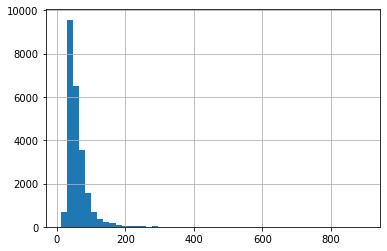

In [51]:
# посмотрим на столбец total_area и данные в нём
data['total_area'].hist(bins=50)
data['total_area'].sort_values(ascending=False).head()

Как мы видим, основная часть данных находится в диапазоне от 12 до 250, но есть несколько случаев, когда продавалась недвижимость и более 500 кв.метров. В целом, для целей нашего анализа ограничимся тем, что все объявления, в которых пплощадь более 250 кв.метров будем считать выбросами и рассматривать не будем. 

In [52]:
# проверим, какую часть данных мы отбрасываем, чтобы не отсечь слишком много
(data['total_area'] > 250).mean()
# получается меньше половины процента. можем смело отбросить эти данные

0.004735729386892177

<AxesSubplot:>

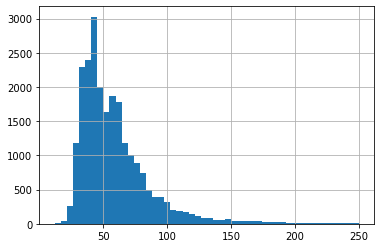

In [53]:
# создадим новую переменную, в которую будем записывать все наши будущие сортировки
data_sorted = data[data['total_area'] <= 250]
# и посмотрим, как это повлияло на гистограмму
data_sorted['total_area'].hist(bins=50)


Другое дело. Теперь гистограмма больше похожа на график распределения. 

13892    2.0
21714    2.0
3238     3.0
23525    3.0
17551    5.0
Name: living_area, dtype: float64

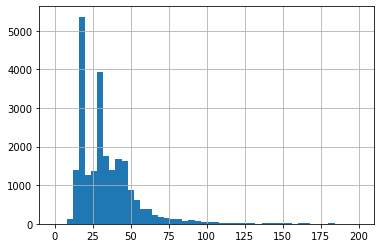

In [55]:
# двигаемся к столбцу living_area
data['living_area'].hist(bins=50, range=(0, 200))
data['living_area'].sort_values().head()

По аналогии с предыдущим столбцом видим, что основная часть данных о жилой площали лежит в пределах ориентировочно до 150 кв.метров. Давайте откинем все варианты, которые превышают этот порог, предварительно проверим, какой процент данным мы отбрасываем.

In [56]:
# проверяем, какую часть данных мы отбрасываем
(data_sorted['living_area'] > 150).mean()


0.002039255671679837

<AxesSubplot:>

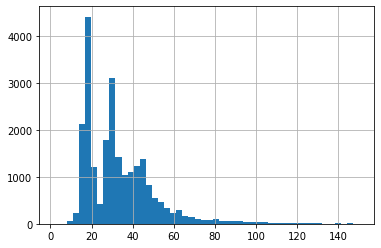

In [57]:
data_sorted = data_sorted[data_sorted['living_area'] <= 150]
data_sorted['living_area'].hist(bins=50)

Помимо этого можно заметить несколько выдающихся пиков на этом графике. Вспомним о том, что столбце living_area был одним из тех, которые мы заполняли медианными значениями, сгруппированными по количеству комнат. Скорее всего, два самых выдающихся пика соответствуют как раз значению комнаты 0,1 - так как их значения очень близки - и 2. Можно представить, что было бы, если бы мы заполняли пропуску, к примеру, одним медианным значением, посчитанным для всего столбца. Мы бы получили один очень большой пик где-то посередине.

19505    112.0
20178    107.0
2487     100.7
5349     100.0
16212     93.2
Name: kitchen_area, dtype: float64

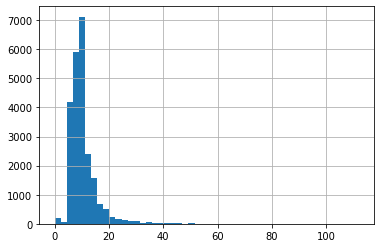

In [58]:
# переходим к столбцу с площадями кухонь и препарируем его
data['kitchen_area'].hist(bins=50)
data['kitchen_area'].sort_values(ascending=False).head()


Отбрасываем верхний хвост графика, который мы можем идентифицировать, как выбросы. Возьмем значения площади не более 50 кв.метров.

In [59]:
# проверяем, какую часть данных мы отбрасываем
(data_sorted['kitchen_area'] > 50).mean()


0.001362281822051937

<AxesSubplot:>

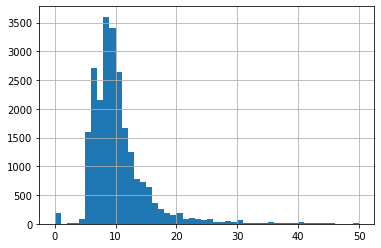

In [60]:
data_sorted = data_sorted[data_sorted['kitchen_area'] <= 50]
data_sorted['kitchen_area'].hist(bins=50)

Опять же, график стал выглядеть лучше. Также заметим, что на этом графике присутствует небольшой пик в районе 0. Вспомним, что, как мы уже обсуждали ранее, не во всех квартирах предусмотрены отдельные кухни.

12950    763000000
19505    420000000
14681    401300000
1435     330000000
15626    300000000
Name: last_price, dtype: int64

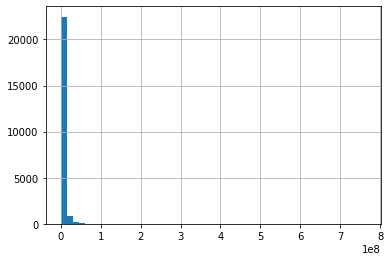

In [61]:
# далее нас ждет столбец цены объекта last_price
data['last_price'].hist(bins=50)
data['last_price'].sort_values(ascending=False).head()


Впрочем, ничего удивительного. Верхнего предела у стоимости недвижимости скорее всего не существует. Как мы видим, в базе присутствуют строки с ценой продажи и более 300 миллионов. Учитывать мы их, конечно же, не будем. А просто возьмем и отбросим всё то, что дороже, скажем, 30 миллионов. Вполне достаточный диапазон для недвижимости в Ленинградской области.

In [62]:
# проверяем, какую часть данных мы отбрасываем
(data_sorted['last_price'] > 30000000).mean()

0.008568505413931282

<AxesSubplot:>

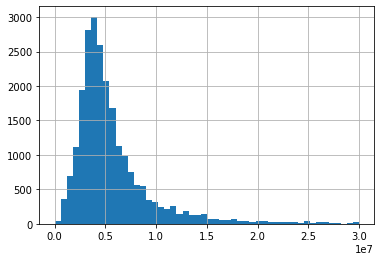

In [63]:
data_sorted = data_sorted[data_sorted['last_price'] <= 30000000]
data_sorted['last_price'].hist(bins=50)

14473    19
18815    16
5349     15
866      14
20789    14
Name: rooms, dtype: int64

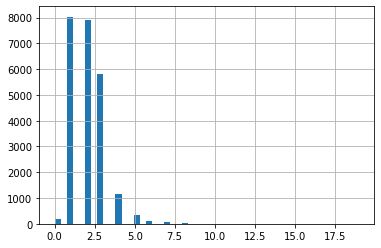

In [64]:
# следующий столбец - rooms
data['rooms'].hist(bins=50)
data['rooms'].sort_values(ascending=False).head()

Здесь график выглядит более дискретным - оно и понятно, разброс в количестве комнат не такой большой, как, например, в ценах. Большая часть данных лежит в пределе до 8 включительно. Его и возьмем.

In [65]:
# проверяем, какую часть данных мы отбрасываем
(data_sorted['rooms'] > 8).mean()

4.299780711183729e-05

<AxesSubplot:>

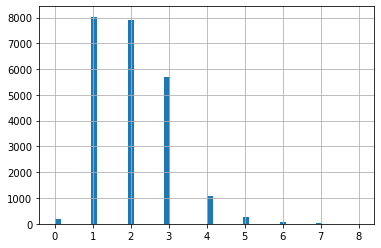

In [66]:
data_sorted = data_sorted[data_sorted['rooms'] <= 8]
data_sorted['rooms'].hist(bins=50)

22822    100.0
3144      32.0
22291     32.0
21334     27.5
17825     27.0
5238      27.0
20440     27.0
21780     27.0
10755     27.0
4868      27.0
5797      27.0
22890     27.0
5660      26.0
11266     25.0
6236      25.0
9363      25.0
355       25.0
18512     25.0
4636      25.0
14357     25.0
5068      24.0
20469     22.6
17466     20.0
15036     14.0
22264     10.3
5853       8.3
17412      8.0
3470       8.0
15717      8.0
20227      6.0
21186      5.8
1387       5.6
7565       5.5
1026       5.3
12609      5.3
464        5.2
1053       5.0
21878      4.9
2798       4.8
1299       4.7
Name: ceiling_height, dtype: float64

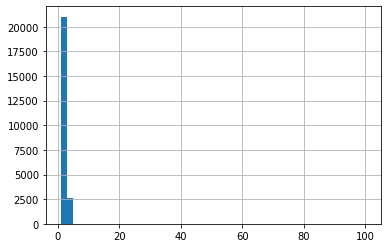

In [67]:
# переходим к высоте потолков ceiling_height
data['ceiling_height'].hist(bins=50)
data['ceiling_height'].sort_values(ascending=False).head(40)


Здесь мы уже видим более странную картину. Если в разбросах площади жилья или её стоимости еще могли допускаться такие разбросы, то с высотой потолка явно что-то не так. Или же в Ленинградской области понастроили дома с потолками в 32 и 27 метров (что вряд ли). Скорее всего здесь явная ошибка в данных - вместо 32 и 27 должны быть 3,2 и 2,7 метров соответственно. Попробуем скорректировать эти значения на нужные. Помимо этого нам также придется отбросить такую аномалию, как 100 (ибо непонятно, что с ней делать) и отсечь выбросы, которые выше чем 4 метра. Скорее всего основная часть данных приходится именно на этот диапазон.

In [68]:
# перенесём запятую для диапазона высот от 20 до 32 метров
data_sorted.loc[(data_sorted['ceiling_height'] >= 20) & (data_sorted['ceiling_height'] <= 32), 'ceiling_height'] = \
data_sorted.loc[(data_sorted['ceiling_height'] >= 20) & (data_sorted['ceiling_height'] <= 32), 'ceiling_height'] / 10


<AxesSubplot:>

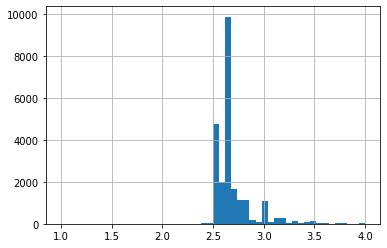

In [69]:
# отрезаем хвост выборки "сверху"
data_sorted = data_sorted[data_sorted['ceiling_height'] <= 4]
data_sorted['ceiling_height'].hist(bins=50)

Теперь мы видим, что у нас есть аномальные значения не только "сверху", но и "снизу". Будем считать, что в среднем высота потолков в квартирах начинается от 2.3 метров и отбросим из выборки всё, что не входит.

In [70]:
# проверяем, какую часть данных мы отбрасываем
((data_sorted['rooms'] > 4) & (data_sorted['rooms'] > 2.3)).mean()

0.014816090963907314

<AxesSubplot:>

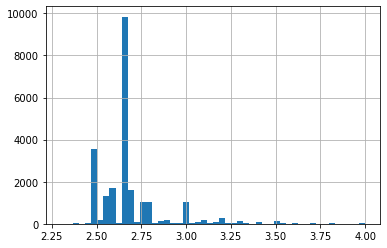

In [71]:
# отрезаем хвост выборки "снизу"
data_sorted = data_sorted[data_sorted['ceiling_height'] >= 2.3]
data_sorted['ceiling_height'].hist(bins=50)

Теперь график приобрел более адекватный вид. Он также выглядит довольно дискретным, как и в случае с количеством комнат - скорее всего это связано с типовыми высотами потолков для недвижимости, которая строилась в разное время. Наибольший пик - это значения медианы по всему столбцу, которой мы заполняли пропуски.

9958     последний
21557    последний
2847     последний
10175    последний
10176    последний
Name: floor_category, dtype: object

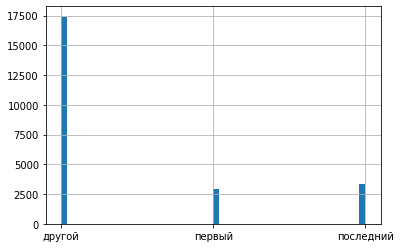

In [72]:
# переходим к столбцу, который мы создавали сами - floor_category
# в нём содержатся только три варианта значений - первый, последний и другой
data['floor_category'].hist(bins=50)
data['floor_category'].sort_values(ascending=False).head()

Как мы видим, большая часть объявлений приходится не на первый и не на последний этажи. Оно и понятно, первых и последних этажей обычно меньше чем суммарно всех остальных. График выглядит адекватно. Дополнительных действий не требуется.

2251     60
16701    52
16904    37
5797     36
11061    36
Name: floors_total, dtype: int64

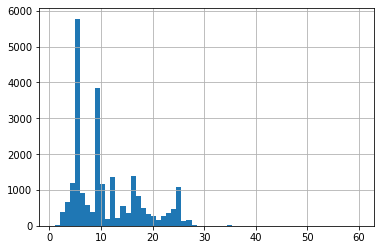

In [73]:
# теперь нас ждёт столбец с общим количеством этажей в доме - floors_total
data['floors_total'].hist(bins=60)
data['floors_total'].sort_values(ascending=False).head()


В целом, здесь ситуация довольно стадартная. Есть определенное количество высотных зданий, которые портят нам график - выбросы. Поэтому выбросим строки, где общее количество этажей в здании превышает 30 этажей. Интересно, что в данном случае пики на графики - это не результат нашей работы с пропусками, а скорее всего результат типичной застройки городов пятиэтажками и девятиэтажками. А вот одиннадцати- и тринадцатиэтажек, почему-то практически нет.

In [74]:
# проверяем, какую часть данных мы отбрасываем
(data_sorted['floors_total'] > 30).mean()

0.001336206896551724

<AxesSubplot:>

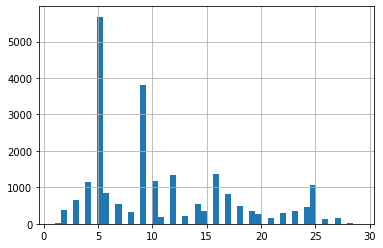

In [75]:
data_sorted = data_sorted[data_sorted['floors_total'] <= 30]
data_sorted['floors_total'].hist(bins=50)

9624     65968
5332     65952
577      65764
20706    65105
5210     64857
Name: cityCenters_nearest, dtype: int64

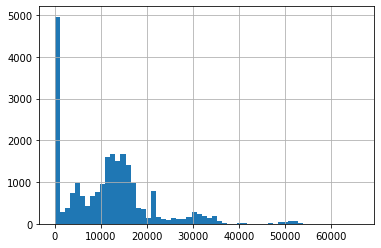

In [76]:
# Вперед! К столбцу cityCenters_nearest!
data['cityCenters_nearest'].hist(bins=60)
data['cityCenters_nearest'].sort_values(ascending=False).head()


На этом графике мы опять же видим результат нашей работы с пропусками (столбец 0). Учтем это при проведении итогового анализа. Остальные данные в целом выглядят довольно адекватно. Пожалуй, оставим как есть.

23032    2984
2655     2905
1859     2888
7841     2880
3860     2847
Name: parks_nearest, dtype: int64

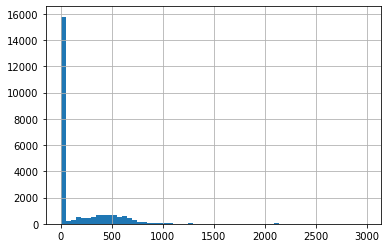

In [77]:
# и последний столбец у нас - это расстояние до ближайшего парка parks_nearest
data['parks_nearest'].hist(bins=60)
data['parks_nearest'].sort_values(ascending=False).head()


Здесь уже график выглядит не настолько адекватным, как в случае с центром города. Явно мешают нулевые значения, которые мы поставили на место пропусков. Давайте посмотрим на график без этих значений.

<AxesSubplot:>

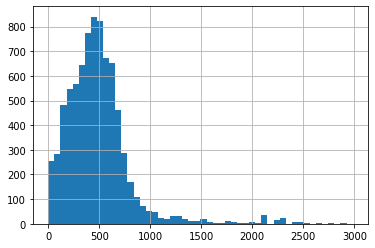

In [78]:
data.loc[data['parks_nearest'] > 0, 'parks_nearest'].hist(bins=50)

Ну вот, другое дело. Отсекаем все, что выше 1700 метров и переходим к промежуточным выводам по этому этапу.

In [79]:
# проверяем, какую часть данных мы отбрасываем
(data_sorted['parks_nearest'] > 1700).mean()

0.0059993957443135225

In [80]:
data_sorted = data_sorted[data_sorted['parks_nearest'] <= 1700]


In [81]:
data_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23030 entries, 0 to 23649
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23030 non-null  int64         
 1   last_price            23030 non-null  int64         
 2   total_area            23030 non-null  float64       
 3   first_day_exposition  23030 non-null  datetime64[ns]
 4   rooms                 23030 non-null  int64         
 5   ceiling_height        23030 non-null  float64       
 6   floors_total          23030 non-null  int64         
 7   living_area           23030 non-null  float64       
 8   floor                 23030 non-null  int64         
 9   is_apartment          23030 non-null  bool          
 10  studio                23030 non-null  bool          
 11  open_plan             23030 non-null  bool          
 12  kitchen_area          23030 non-null  float64       
 13  balcony         

Этот этап с фильтрацией данных был одним из самых насыщенных в плане визуализации. Мы просмотрели основные столбцы данных и с помощью гистограмм оценили их на адекватность и наличие выбросов или аномалий. После этого мы, где это требуется, исправили аномалии (например, в столбце с высотой потолка), а часть выбросов отфильтровали, чтобы они не мешали дальнейшему анализу. При этом с учетом всей фильтрации столбцов и удаления строк с пропусками мы потеряли менее 700 строк относительно изначального объёма данных, что составляет менее 3%.

#### Как быстро продавались квартиры?

Исследуем столбец days_exposition, чтобы оценить среднее и медиану количества дней, которые требовались для продажи квартир.

Медиана столбца days_exposition:94.0


count    19982.000000
mean       178.407967
std        217.001297
min          1.000000
25%         44.250000
50%         94.000000
75%        227.000000
max       1580.000000
Name: days_exposition, dtype: float64

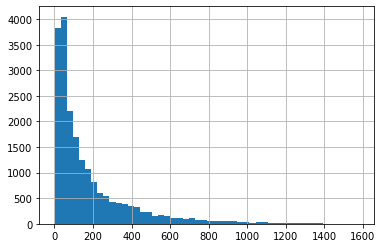

In [82]:
print(f'Медиана столбца days_exposition:{data_sorted["days_exposition"].median()}')
data_sorted['days_exposition'].hist(bins=50)
data_sorted['days_exposition'].describe()

Итак мыможем сделать следующие промежуточные выводы: 
- Среднее значение скорости продаж квартир (в днях) равняется 178, а медиана - 94. Поскольку медиана менее подвержена влиянию выбросов, она показывает более наглядное значение того, как быстро обычно продаются квартиры. 
- Ровно половина собственников продали свою недвижимость быстрее за 94 дня или быстрее. 
- Поскольку значение стандартного отклонения довольно велико (217), можно судить о том, насколько большой разброс бывает в значениях этого столбца. 
- В целом, исходя из этих данных, продажа квартиры в течение одного года может считаться не таким уж и редким событием. Редким можно назвать событие, когда недвижимость продается в течение двух лет и более.

#### Какие факторы больше всего влияют на стоимость объекта?

Теперь исследуем, какие же факторы больше всего влияют на итоговую стоимость. Рассмотрим следующие столбцы:
- общей площади (total_area);
- жилой площади (living_area);
- площади кухни (kitchen_area);
- количества комнат (rooms);
- этажа, на котором расположена квартира (первый, последний, другой) (floor_category);
- даты размещения (день недели, месяц, год) (weekday_exposition, month_exposition, year_exposition).

In [83]:
# выделим отдельную таблицу только с интересующими нас столбцами

data_sorted_for_price = data_sorted[[
    'last_price',
    'total_area',
    'living_area',
    'kitchen_area',
    'rooms',
    'floor_category',
    'weekday_exposition',
    'month_exposition',
    'year_exposition'
]]
data_sorted_for_price.head()


,last_price,total_area,living_area,kitchen_area,rooms,floor_category,weekday_exposition,month_exposition,year_exposition
0,13000000,108.0,51.0,25.0,3,другой,3,3,2019
1,3350000,40.4,18.6,11.0,1,первый,1,12,2018
2,5196000,56.0,34.3,8.3,2,другой,3,8,2015
4,10000000,100.0,32.0,41.0,2,другой,1,6,2018
5,2890000,30.4,14.4,9.1,1,другой,0,9,2018


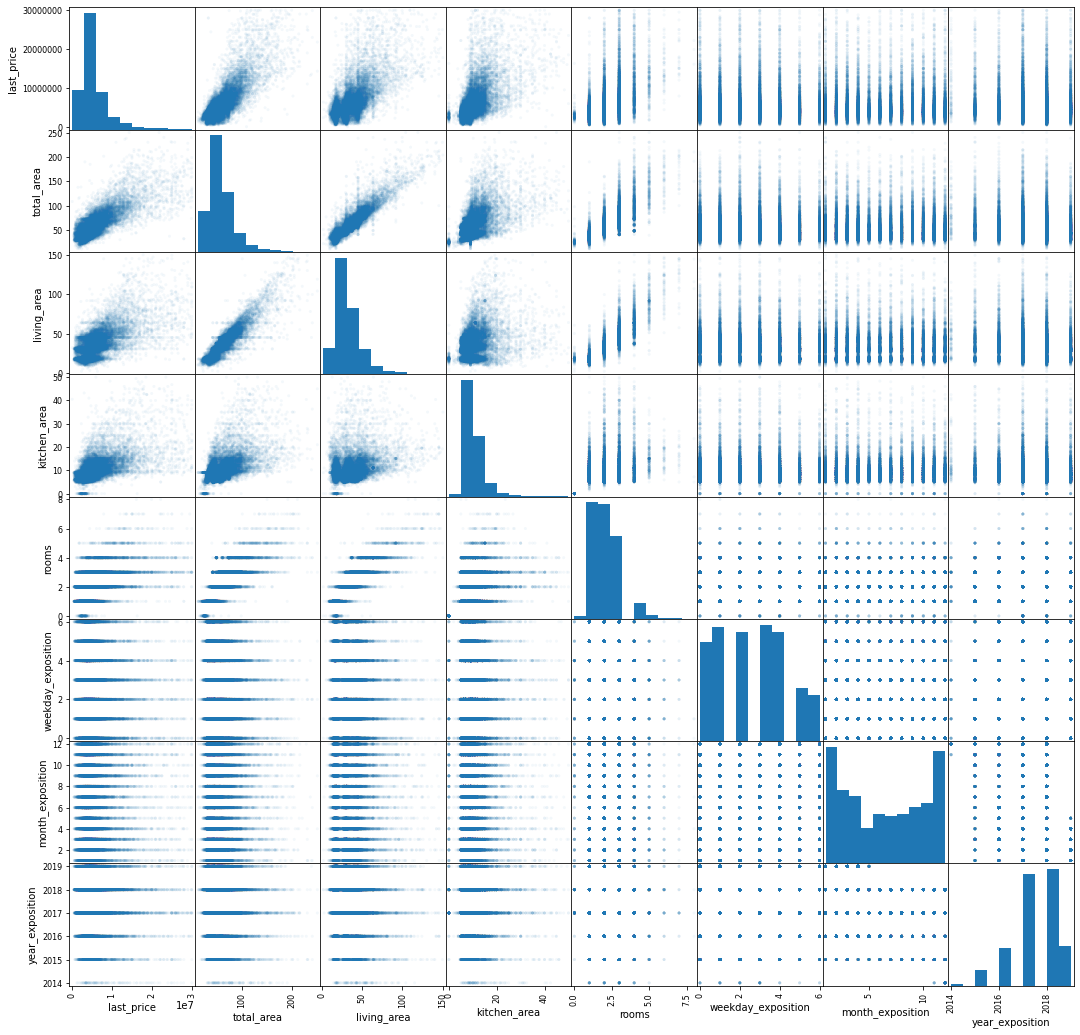

In [84]:
# построим диаграммы рассеяния для данной таблицы
pd.plotting.scatter_matrix(data_sorted_for_price, figsize=(18, 18), alpha=0.05)
None

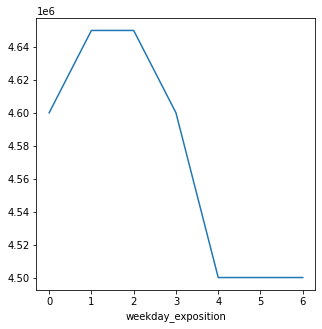

In [85]:
data_sorted_for_price.groupby('weekday_exposition')['last_price'].median().plot(figsize=(5, 5))
None

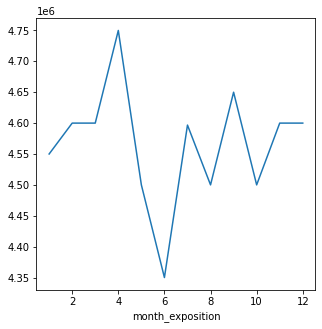

In [86]:
data_sorted_for_price.groupby('month_exposition')['last_price'].median().plot(figsize=(5, 5))
None

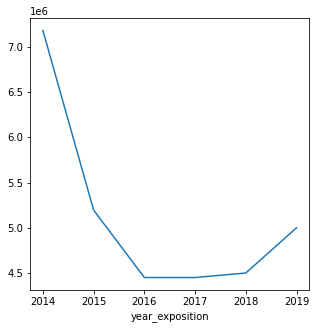

In [87]:
data_sorted_for_price.groupby('year_exposition')['last_price'].median().plot(figsize=(5, 5))
None

Даже не считая коээфициент корреляции по некоторым графикам уже можно сказать, что зависимость конечной цены от заданного параметра есть или её практически нет.

Разберём более подробно. По сути для анализа нам достаточно только первой строки графиков, поскольку именно они построены с переменной last_price по оси Y. 

Первый график является обычной гистограммой last_price и показывает частоту появления той или иной цены. Он в целом схож с большинством других гистограмм, полученных нами ранее.

Следующие три графика, построенные для столбцов total_area, living_area и kitchen_area, уже гораздо более интересны и на первый взгляд демонстрируют некоторую корреляцию между итоговой ценой и соответствующими параметрами. Причем три графика последовательно "ухудшаются", что может говорить о том, что общая площадь квартиры оказывает наибольшее влияние на стоимость, затем идёт общая жилая площадь и наконец плозадь кухни.

График относительно количества комнат в квартире (rooms), конечно, менее показателен как минимум из-за того, что данные о количестве комнат очень дискретны (видны только вертикальные столбцы, соответствующие количеству комнат), однако и по нему можно сказать, что есть некая тенденция к тому, что с увеличением числа комнат, стоимость жилья также увеличивается (разумеется, ведь обычно растет и общая площадь).

А вот графики для дня, месяца и года, когда было выложено объявление, практически не демонстрируют какой-либо корреляции (но это опять-таки на первый взгляд). По ощущениям можно сказать, разве что о том, что объявления, выложенные в будние дни, имеют более высокие пики стоимости чем оные для выходных. Вполне вероятно, это связано с тем, что некоторые объявления формируются и выкладываются риелторами, которые обычно работают в будни и которые могут более профессионально оценить и сформировать объявление. По графику месяцев можно сказать, что зимой в среднем было больше объявлений и они были дороже чем в летний сезон. А по графику года публикации объявлений можно сделать вывод лишь о том, что с каждым годом стоимость квартир дорожает, как и количество выложенных объявлений. Это не работает только для последнего года на графика, вероятно, потому, что данные были собраны не за весь календарный год.



In [88]:
# теперь посчитаем коэффициент корреляции Пирсона для нашей таблицы относительно last_price
data_sorted_for_price.corr().head(1)

,last_price,total_area,living_area,kitchen_area,rooms,weekday_exposition,month_exposition,year_exposition
last_price,1.0,0.786716,0.655791,0.575771,0.504561,-0.0194,0.004259,-0.036031


Как мы и обсуждали ранее, столбцы total_area, living_area и kitchen_area имеют максимальные положительные значения коэффициентов корреляции среди всех столбцов (0.79 - высокая, 0.66 - заметная и 0.58 - заметная соответственно). И это не удивительно, ведь общая площадь квартиры - один из основных параметров, определяющих её стоимость. Как видим из таблицы, жилая площадь и площадь кухни оказывают уже меньшее влияние на цену, однако и они имеют значение, ведь из них складывается общая стоимость.

Столбец с количеством комнат из всех рассматриваемых в этом задании характеристик квартиры имеет наимешьний коэффициент корреляции. Скорее всего отчасти это связано с нелинейностью роста площади квартиры и количества её комнат. Но, как мы помним, коэффициент Пирсона показывает только линейную корреляцию двух величин, поэтому, вполне возможно, что взаимосвязь есть, просто она выходит за рамки линейности.

Ну а что касается дней недели, месяца и года публикации объявлений, как показывает коэффициент корреляций здесь практически отсутствует, а где-то она даже слегка ушла в отрицательную область. Делаем вывод, что опять же линейная зависимость этих величин и итоговой стоимости не прослеживается, либо для этого недостаточно данных, ведь, например, известно, что обычно с каждым годом стоимость квартир только увеличивается. Поэтому вполне возможно, что некая взаимосвязь есть, но она выходит за рамки линейности и данного проекта :)

####  Расчет средней цены квадратного метра

Теперь, согласно заданию, найдем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [89]:
# создадим сводную таблицу для населенных пунктов и цен за кв.метр
locality_meter_price_pivot = \
data_sorted.pivot_table(
    index='locality_name',
    values='one_meter_price',
    aggfunc=['count', 'mean']
)

# отбросим дробные части для средний значений цены за метр
locality_meter_price_pivot['mean'] = locality_meter_price_pivot['mean'].astype(int)
# переименуем столбцы и выведем 10 населенных пунктов с наибольшим количество объявлений
locality_meter_price_pivot.columns = ['ad_count', 'mean_meter_price']
locality_meter_price_pivot_top10 = locality_meter_price_pivot.sort_values('ad_count', ascending=False).head(10)
locality_meter_price_pivot_top10

,ad_count,mean_meter_price
locality_name,,
Санкт-Петербург,15141,110297
поселок Мурино,556,85681
поселок Шушары,440,78677
Всеволожск,396,68670
Пушкин,363,102860
Колпино,334,75232
поселок Парголово,327,90175
Гатчина,307,68746
деревня Кудрово,299,92473


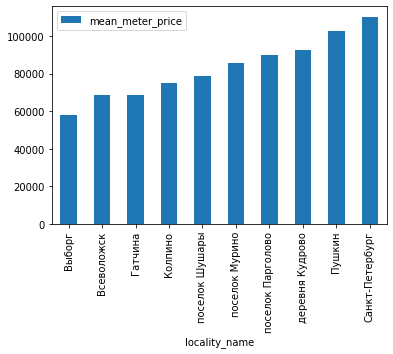

In [90]:
locality_meter_price_pivot_top10.sort_values('mean_meter_price').plot(y='mean_meter_price', kind='bar')
None

In [91]:
# посмотрим на характеристики этой выборки
locality_meter_price_pivot_top10.describe()

,ad_count,mean_meter_price
count,10.000000,10.000000
mean,1839.700000,83100.100000
std,4674.435582,16299.091293
min,234.000000,58190.000000
25%,312.000000,70367.500000
50%,348.500000,82179.000000
75%,429.000000,91898.500000
max,15141.000000,110297.000000


Как мы видим из данной таблицы, средняя цена за квадратный метр в 10 населенных пунктах с наибольшим количеством объявлений составляет около 83000. Минимальная стоимость метра - около 58000 - в Выборге, а максимальная - более 110000 - ожидаемо, в Санкт-Петербурге.

#### Оценка влияния расстояния от центра Санкт-Петербурга на стоимость недвижимости.

Теперь перейдем к оценке только той недвижимости, которая находится в пределах Санкт-Петербурга и выясним среднюю стоимость квадратного метра жилья на каждом километре удаления от центра города. Также мы визуализируем данную зависимость и проанализуруем её результаты.

In [92]:
# отфильтруем те строки, которые относятся только к Санкт-Петербургу
spb_data = data_sorted[data_sorted['locality_name'] == 'Санкт-Петербург']
spb_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_meter_price,weekday_exposition,month_exposition,year_exposition,floor_category,cityCenters_dist_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482,2,755,NaN,120370.37,3,3,2019,другой,16
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,90,2,574,558.0,92785.71,3,8,2015,другой,14
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112,1,48,121.0,100000.00,1,6,2018,другой,8
7,5,7915000,71.6,2019-04-18,2,2.65,24,30.5,22,False,...,0,0,0,NaN,110544.69,3,4,2019,другой,12
9,18,5400000,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,0,0,0,289.0,88524.59,6,2,2017,другой,15


,one_meter_price
cityCenters_dist_km,
0,116000.381538
1,144950.799042
2,127446.216278
3,116769.976024
4,125000.786031
5,131675.466496
6,131232.346190
7,131463.393224
8,123246.763218


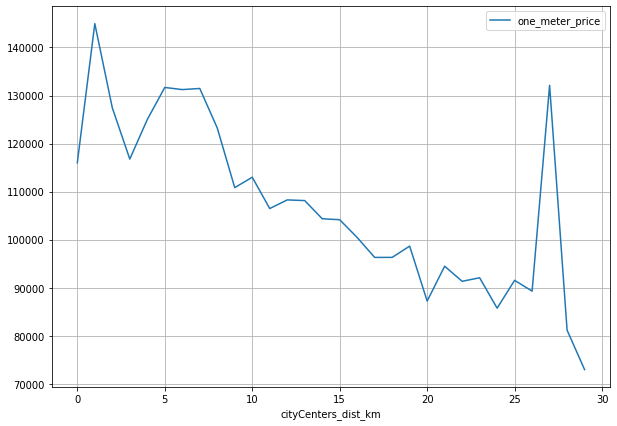

In [93]:
# создадим сводную таблицу с данными о расстоянии в километрах от центра города и соответствующей стоимостью квадратного метра
# а также визуализируем результат
citycenter_meter_price_pivot = spb_data.pivot_table(index='cityCenters_dist_km', values='one_meter_price')
citycenter_meter_price_pivot.plot(grid=True, figsize=(10,7))
citycenter_meter_price_pivot.head(10)


За исключением некоторых всплесков на графике, мы можем констатировать то, что с увеличением расстояния от центра Петербурга средняя стоимость одного квадратного метра жилья снижается. 

Также мы видимо некий пик ближе к правой части графика, который с одной стороны может оказаться каким-то выбросом в данных, а с другой стороны может коррелировать с каким-либо дорогостоящим районом Петербурга, который находится на некотором отдалении от центра города. Но в целом явно прослеживается тенденция к снижению стоимости метра жилья при удалении от центра.

### Общий вывод

В данном проекте мы рассматривали данные о продаже квартир в Ленинградской области за несколько лет. Основными задачами являлись:
- проведение предобработки данных, включая работу с пропусками и дубликатами;
- дополнение основной таблицы новыми расчетными данными и категоризация уже имеющихся;
- анализ и обработка выбросов и аномалий;
- оценка скорости продажи квартир;
- выявление факторов, которые наиболее сильно влияют на стоимость недвижимости;
- расчет средней цены квадратного метра для наиболее популярных населенных пунктов;
- оценка влияния расстояния от центра города Санкт-Петербурга на среднюю стоимость квадратного метра жилья.

На этапе предобработки данных была проведена работа с пропусками в таблице. 
- Большая часть пропусков была заполнена медианными значениями, сгруппированными по другим столбцам таблицы;
- Для заполнения высоты потолков брались данные, сгруппированные по аналогичному району нахождения квартиры;
- Для заполнения жилой площади бралась медиана по другим квартирам с тем же количеством комнат; 
- Столбцы с описанием апартаментов или наличия балкона заполнялись нулями, предполагая, что если такие данные не были указаны, значит квартира не имеет балкона и не является апартаментом. 
- Также были обработаны данные для количества и расстояния до парков и прудов. Значения брались из медианных значений по соответствующим районам. 
- В итоге пропуски остались только в столбце со значениями длительности размещения объявления, так как эти данные нельзя заполнить случайными или медианными значениями.

Далее были обработаны столбцы таблицы, проанализированы данные в них и изменены типы данных, соответствующие целям столбцов.
- Столбцы 'last_price', 'floors_total', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest' переведены в формат целых чисел int$
- Cтолбец first_day_exposition - в формат datetime.

После этого, согласно заданию, в таблицу были внесены новые данные:
- О расчетной стоимости одного метра жилья;
- Данные о дне/месяце/годе размещения объявления о продаже;
- Были категоризированы данные об этажности квартир (по категориям "первый", "последний" и "другой");
- Также добавлен столбец с расстоянием от квартиры до центра города в км.

Далее был проведен анализ имеющихся данных для основных столбцов таблицы:
- Были визуализированы данные каждого такого столбца;
- Оценена адекватность имеющихся данных;
- При необходимости сделан срез для того, чтобы исключить слишком сильные выбросы, которые могли повлиять на качество последующего анализа;
    - Общая площадь квартир была ограничена 250 кв.м.;
    - Жилая площадь - 150кв.м.;
    - Площадь кухни - 50 кв.м.;
    - Итоговая стоимость продажи - 30 000 000;
    - Количество комнат - 8;
    - Высота потолка - от 2.3 до 4 метров;
    - Этажность здания - до 30 этажей;
    - Расстояние до ближайшего парка - до 1700 метров включительно.
- Также были исправлены явные аномалии в данных, такие как значения потолков квартир 20 метров и выше.

Также был проведен анализ того, как быстро, согласно имеющимся данным, в среднем продавались квартиры.
- Среднее значение скорости продаж квартир (в днях) равняется 178, а медиана - 94. Поскольку медиана менее подвержена влиянию выбросов, она показывает более наглядное значение того, как быстро обычно продаются квартиры. 
- Ровно половина собственников продали свою недвижимость быстрее за 94 дня или быстрее. 
- Поскольку значение стандартного отклонения довольно велико (217), можно судить о том, насколько большой разброс бывает в значениях этого столбца. 
- В целом, исходя из этих данных, продажа квартиры в течение одного года может считаться не таким уж и редким событием. Редким можно назвать событие, когда недвижимость продается в течение двух лет и более.

Был проведен анализ факторов, которые наиболее сильно влияют на конечную стоимость продажи квартиры.  
Это такие факторы как (в порядке убывания влияния):
- Общая площадь;
- Жилая площадь;
- Площадь кухни;
- Количество комнат;  
Также было установлено отсутствие линейной зависимости стоимости продажи от дня/месяца/года создания объявления.

Были проанализированы данные о средней стоимости одного квадратного метра жилья для 10 населенных пунктов с наибольшим количеством объявлений. Было установлено:
- Средняя цена за квадратный метр составляет около 83000;
- Минимальная стоимость метра - около 58000 - в Выборге;
- Максимальная - более 110000 - в Санкт-Петербурге.

В конце была визуализирована зависимость стоимости одного квадратного метра жилья от расстояния до центра Санкт-Петербурга. Было установлено, что с удалением от центра города стоимость одного метра падает за исключением одного пика около 27км. Возможно, что данный пик соответствует какому-то более дорогостоящему району города.

Итого: задачи проекта выполнены, а цели достигнуты.


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод